In [1]:
import torch
from torch.nn import functional as F
from config import *
from encoder import Encoder
from modules import LLM

In [2]:
def get_loss_lr(log_file):
    with open(log_file) as f:
        lines = f.readlines()

    losses = []
    lrs = []
    for line in lines:
        step = int(line.split()[0][4:-1])
        loss = float(line.split()[1][5:])
        lr = float(line.split()[3][3:])
        if len(losses) > step - 1:
            losses[step - 1] = loss
            lrs[step - 1] = lr
        else:
            losses.append(loss)
            lrs.append(lr)
    return losses, lrs

In [3]:
import matplotlib.pyplot as plt

9.241622850298882


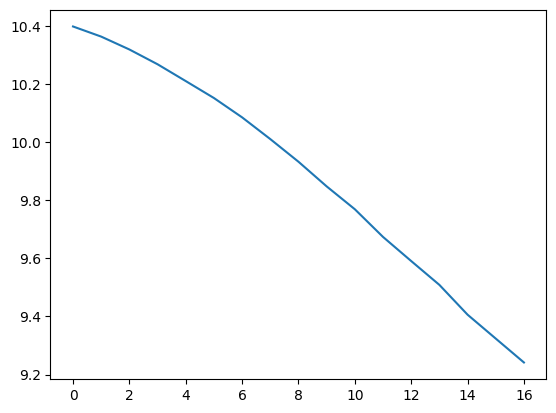

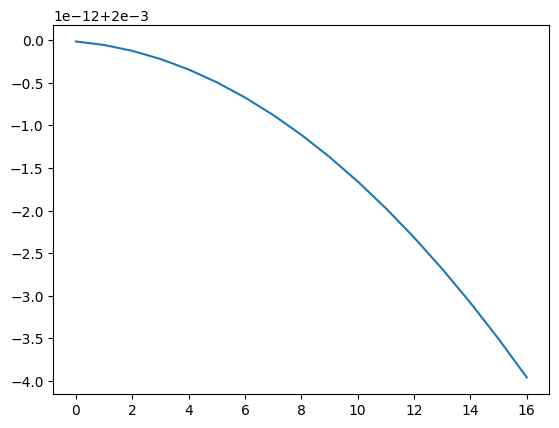

In [4]:
losses, lrs = get_loss_lr("losses.log")
print(min(losses))
plt.plot(losses)
plt.show()
plt.plot(lrs)
plt.show()

In [5]:
from dataloader import BinaryDataset, collate_fn
from torch.utils.data import DataLoader

loader = DataLoader(
    BinaryDataset("openwebtext/openwebtext.txt.bin.part0", MAX_LENGTH),
    batch_size=1,
    shuffle=False,
    num_workers=1,
    collate_fn=collate_fn
)
encoder = Encoder.from_path("encoder.json")

In [6]:
llm = LLM(encoder.vocab_size, MODEL_DIM, MAX_LENGTH, N_HEADS, N_BLOCKS, 0).to("cuda")
llm.compile()

In [7]:
length = MAX_LENGTH
for x, y, n_tokens in loader:
    x = F.pad(x.to("cuda")[:, :length, ...], (MAX_LENGTH - length, 0), value=0)
    y = F.pad(y.to("cuda")[:, :length, ...], (MAX_LENGTH - length, 0), value=0)
    break

In [8]:
torch.set_float32_matmul_precision("high")
logits = llm(x)
print(loss := F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1)))

tensor(10.3950, device='cuda:0', grad_fn=<NllLossBackward0>)


In [9]:
out = logits[0].argmax(dim=-1).tolist()[MAX_LENGTH - length:]
print(encoder.decode(x[0].tolist()))
print(encoder.decode(y[0].tolist()))
print(encoder.decode(out))

If you live abroad and are requesting an ITIN for a foreign child who has been adopted or legally placed in your home pending adoption, remember to include a copy of the legal documents evidencing your relationship to the child. If you live abroad and are requesting an ITIN for a foreign child who has been adopted or legally placed in your home pending adoption, remember to include a copy of the legal documents evidencing your relationship to the child. When it comes to ITINs for dependents only IRS employees serving as certifying acceptance agents are empowered to evaluate your dependent's passport on the spot and immediately return the passport. When it comes to ITINs for dependents only IRS employees serving as certifying acceptance agents are empowered to evaluate your dependent's passport on the spot and immediately return the passport. Protesters take to the street in Chicago after recent grand jury decisions in police-involved deaths in New York, Cleveland and Ferguson, Mo. (Pho

In [10]:
loss.backward()

W1110 13:45:51.363025 124086564947648 torch/fx/experimental/symbolic_shapes.py:4449] [0/0] rindex is not in var_ranges, defaulting to unknown range.


In [11]:
llm.blocks[0].attn.k_proj.weight.requires_grad

True

In [12]:
llm.blocks[0].attn.k_proj.weight.grad is None # WTF?

False

In [13]:
llm.lmhead.weight.grad is None

False